# Reconstruction of static Europe climate data
_Author_: __Jakub Walczak__

_Goal_: The goal of these experiments is to evaluate and compare the common climate data reconstruction methods (IDW and kriging) with deep learning methods relying on Implicit Neural Representation (INR).

_Methods_: 
1. Inwerse Distance Weightining (IDW),
2. Ordinary kriging,
3. Implicit Neural Representation with periodic activation function (SIREN).

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import xarray as xr
import climatrix as cm

In [2]:
EXP_DIR = Path("./results")
EXP_DIR.mkdir(parents=True, exist_ok=True)

In [3]:
N_BINS = 40
HIST_RANGE = (-10.0, 10)

In [4]:
def plot(comp):
    fig, ax = plt.subplots(1, 2, figsize=(24, 10))
    comp.plot_diff(ax=ax[0])
    comp.plot_signed_diff_hist(ax=ax[1], n_bins=N_BINS, limits=HIST_RANGE)    

### 1. Subset static temperature data for Europe

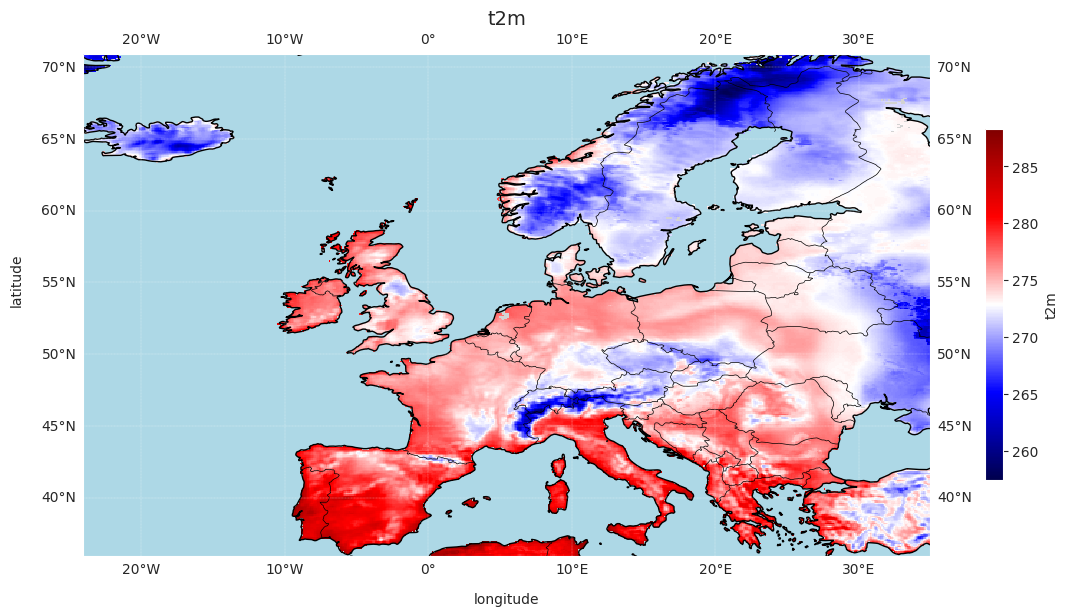

In [5]:
dset = xr.open_dataset("/home/jakub/tul/research/climatrix/data/era5-land.nc").cm
europe = dset.subset(north=71, south=36, west=-24, east=35).isel_time(0)
europe.plot();

## 2. Sample uniformly $N$ points

Loading sparse dataset...


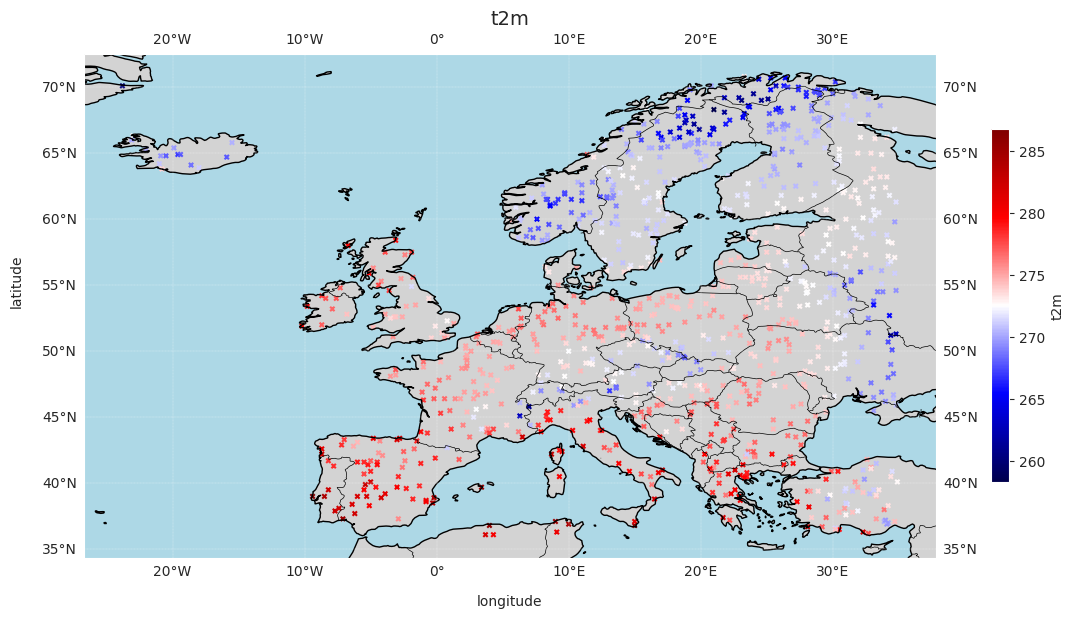

In [6]:
sparse_file = EXP_DIR / "sparse.nc"
if sparse_file.exists():
    print("Loading sparse dataset...")
    sparse = xr.open_dataset(sparse_file).cm
else:
    print("Sampling dataset...")
    sparse = europe.sample(number=1_000, kind="uniform", nan_policy="resample")
    sparse.da.to_netcdf(sparse_file)
sparse.plot();

## 3a. Reconstruct with IDW

01-04-2025 15:25:59 INFO | climatrix.reconstruct.idw | Reconstructing static dataset...


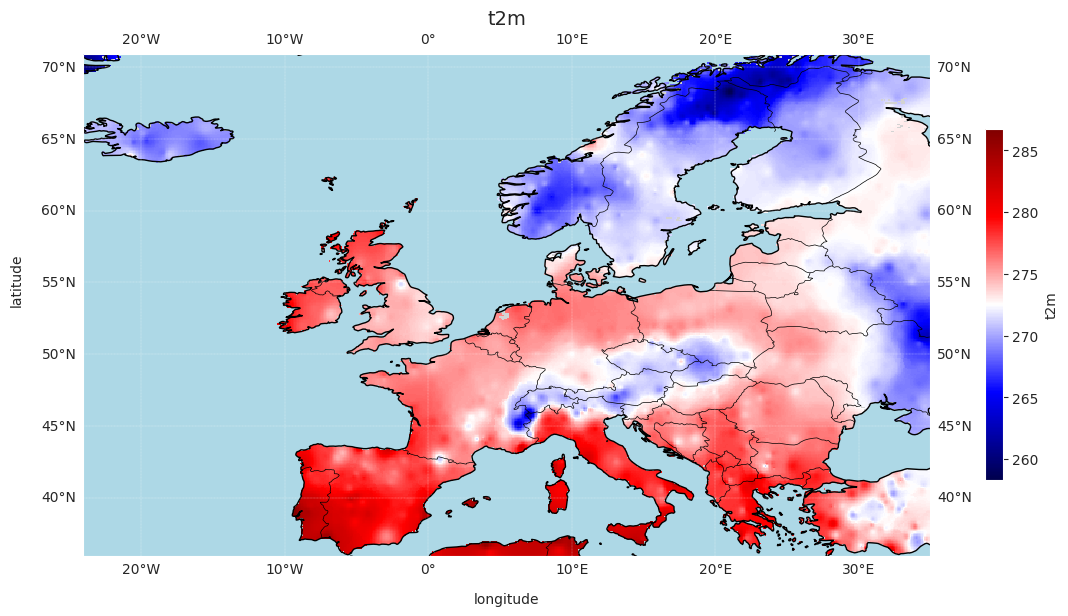

In [7]:
idw_dense = sparse.reconstruct(europe.domain, method="idw", k=10)
idw_dense = idw_dense.mask_nan(europe)
idw_dense.plot();

In [8]:
idw_comp = cm.Comparison(predicted_dataset=idw_dense, target_dataset=europe)
idw_comp.save_report(EXP_DIR / "idw")

/home/jakub/tul/research/climatrix/src/climatrix/comparison.py:189: UserWarning: The target directory already exists and will be overwritten.
  warnings.warn("The target directory already exists and will be overwritten.")


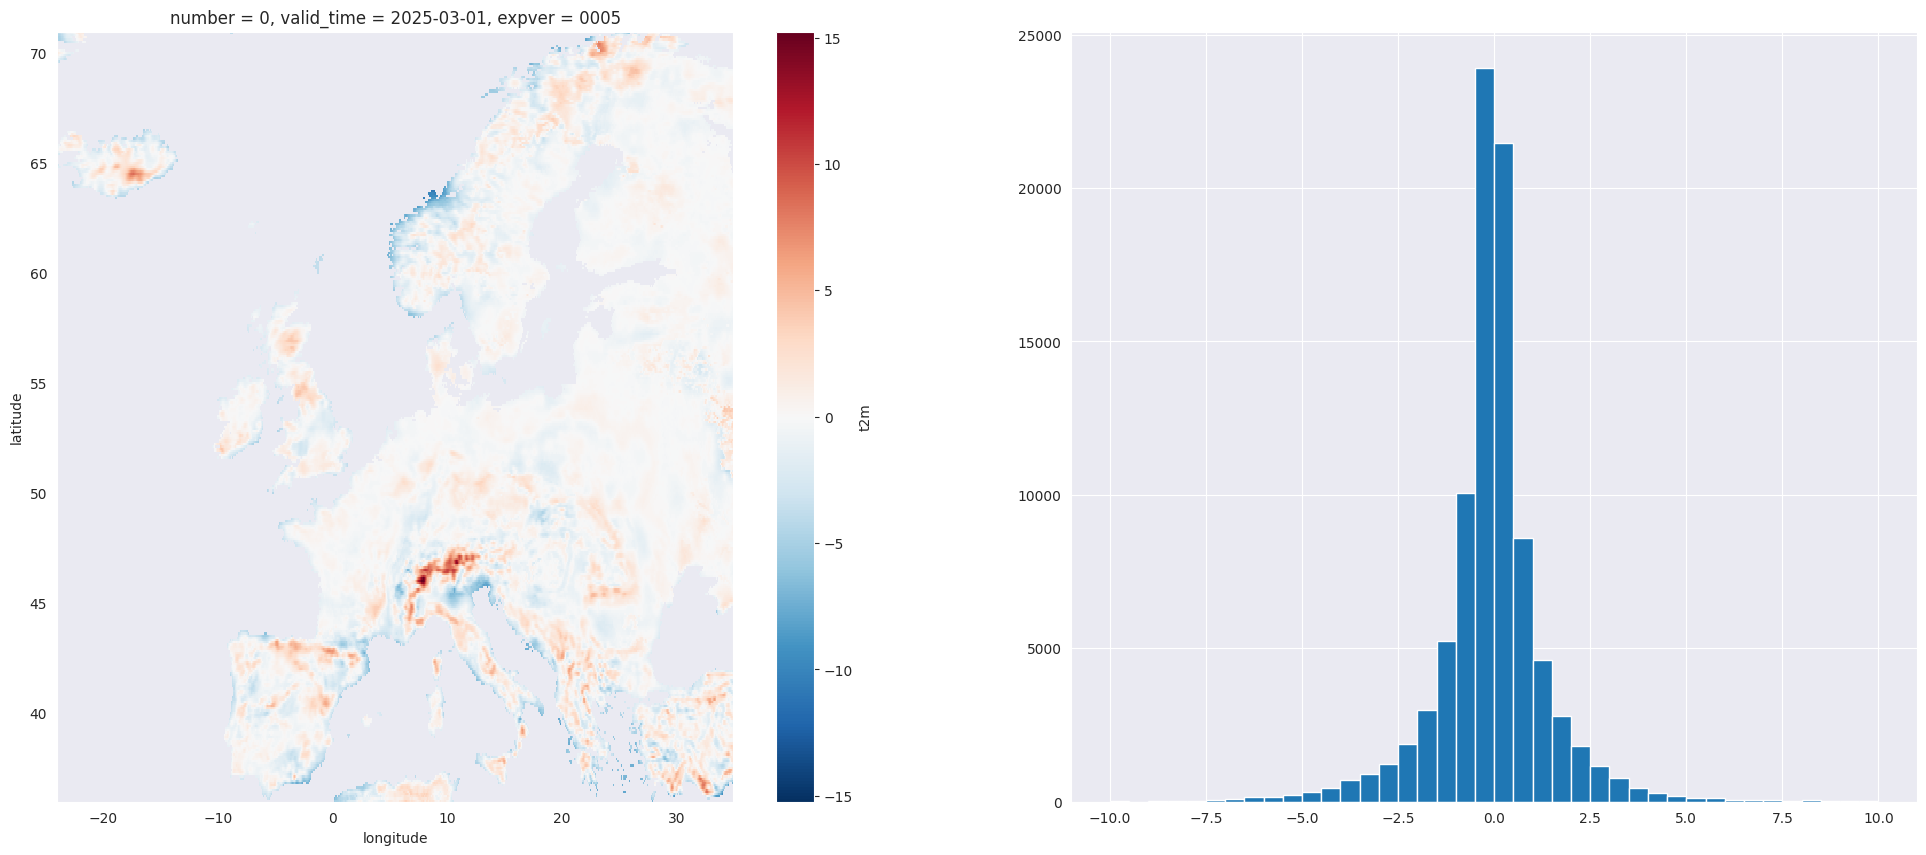

In [9]:
plot(idw_comp);

## 3b. Reconstruction with Ordinary Kriging

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'linear' Variogram Model
Slope: 0.5010779125685182
Nugget: 5.8799865782858465 

Calculating statistics on variogram model fit...
01-04-2025 15:26:24 INFO | climatrix.reconstruct.kriging | Performing Ordinary Kriging reconstruction...
Executing Ordinary Kriging...



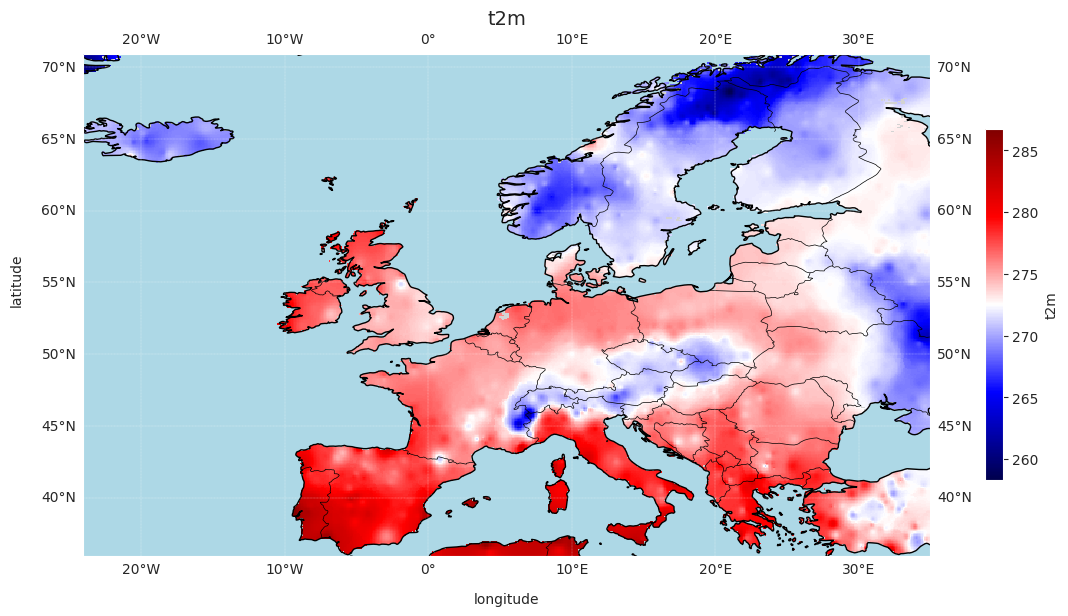

In [10]:
ok_dense = sparse.reconstruct(europe.domain, method="ok", verbose=True, backend="loop")
ok_dense = idw_dense.mask_nan(europe)
ok_dense.plot();

In [11]:
ok_comp = cm.Comparison(predicted_dataset=ok_dense, target_dataset=europe)
ok_comp.save_report(EXP_DIR / "ok")

/home/jakub/tul/research/climatrix/src/climatrix/comparison.py:189: UserWarning: The target directory already exists and will be overwritten.
  warnings.warn("The target directory already exists and will be overwritten.")


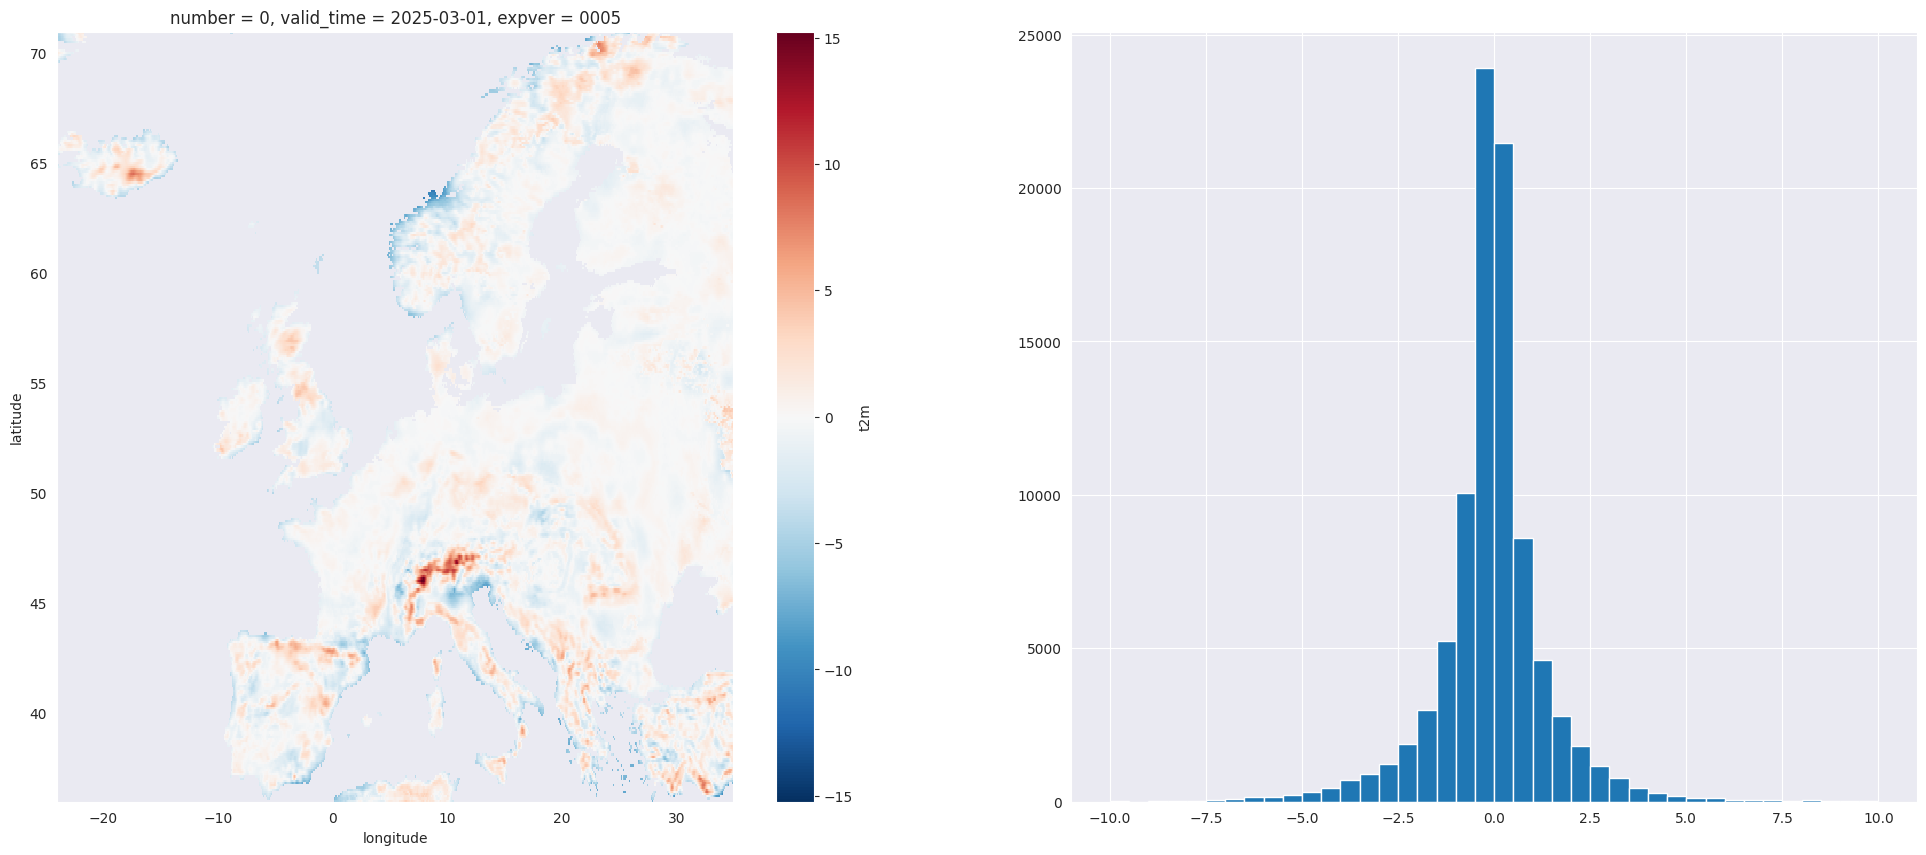

In [12]:
plot(ok_comp);

## 3c. Reconstruction with SIREN

In [13]:
checkpoint = EXP_DIR / "siren.ckpt"

In [18]:
siren_dense = sparse.reconstruct(europe.domain, method="siren", checkpoint=checkpoint)

01-04-2025 15:56:26 INFO | climatrix.reconstruct.siren.siren | Using checkpoint path: /home/jakub/tul/research/climatrix/experiments/jwalczak/results/siren.ckpt
01-04-2025 15:56:26 INFO | climatrix.reconstruct.siren.siren | Initializing SIREN model...
01-04-2025 15:56:26 INFO | climatrix.reconstruct.siren.siren | Loading checkpoint from /home/jakub/tul/research/climatrix/experiments/jwalczak/results/siren.ckpt...
01-04-2025 15:56:26 INFO | climatrix.reconstruct.siren.siren | Creating mini-batches for surface reconstruction...
01-04-2025 15:56:26 INFO | climatrix.reconstruct.siren.siren | Processing mini-batch 1/1...


ValueError: cannot reshape array of size 1000 into shape (350,590)

In [16]:
siren_comp = cm.Comparison(predicted_dataset=siren_dense, target_dataset=europe)
siren_comp.save_report(EXP_DIR / "siren")

NameError: name 'siren_dense' is not defined

In [ ]:
plot(siren_comp);

## 4. Comparison of histograms

NameError: name 'siren_comp' is not defined

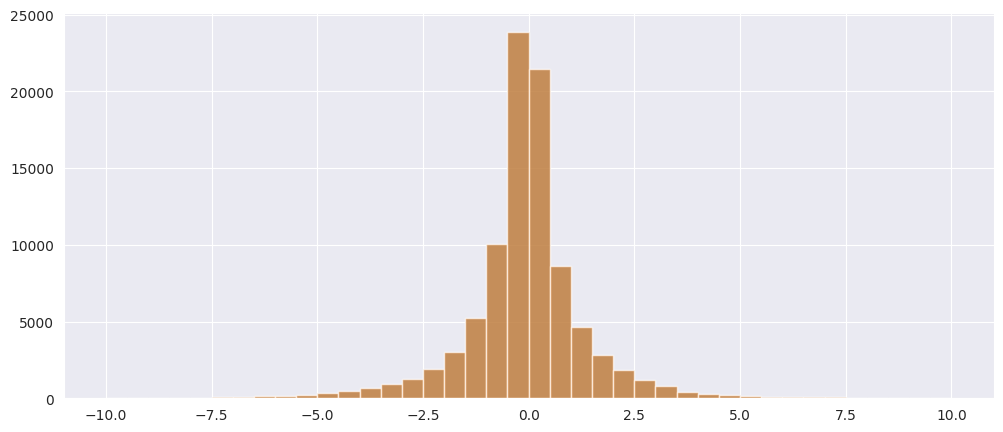

In [17]:
fig, ax = plt.subplots(figsize=(12, 5))
idw_comp.plot_signed_diff_hist(ax=ax, n_bins=N_BINS, limits=HIST_RANGE, alpha=0.6)    
ok_comp.plot_signed_diff_hist(ax=ax, n_bins=N_BINS, limits=HIST_RANGE, alpha=0.6)    
siren_comp.plot_signed_diff_hist(ax=ax, n_bins=N_BINS, limits=HIST_RANGE, alpha=0.6)    